In [677]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate 100 wind power scenarios


filename = 'data/storeskar inflow.xlsx'
historical_inflow_data = pd.read_excel(filename, skiprows=1)
historical_inflow_data.time = pd.to_datetime(historical_inflow_data.time)
historical_inflow_data.set_index('time',inplace=True)
# historical_wind_data.drop(historical_wind_data.columns[[3,4]], axis=1, inplace=True)
# print(historical_wind_data.head())
# print(historical_wind_data.tail())

ini_y=1958
end_y=2019

inflow_scenarios = {}
for year in range(ini_y, end_y+1):
    one_year_inflow = historical_inflow_data[(historical_inflow_data.index.year==year)]['inflow']#*max_wind
    inflow_scenarios[year] = one_year_inflow.reset_index(drop=True)



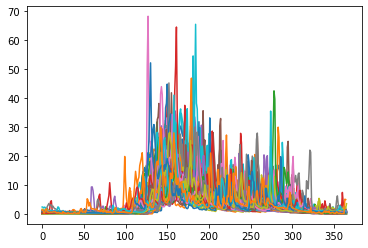

In [678]:
##Plot scenarios
#plt.plot(wind_scenarios, label='planned', color='black')
for i in range(ini_y, end_y+1):
    plt.plot(inflow_scenarios[i])
plt.show()

In [679]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [680]:
print(len(inflow_scenarios))

62


In [681]:
series_lengths = {len(inflow_scenarios[year]) for year in range(ini_y,end_y+1)}
print(series_lengths)


{365, 366}


In [682]:
min_len = min(series_lengths)
min_series = None
for year in range(ini_y,end_y+1):
    if len(inflow_scenarios[year]) == min_len:
        min_series = inflow_scenarios[year]
for i in range(ini_y,end_y+1):
    if len(inflow_scenarios[i])!= min_len:
        inflow_scenarios[i] = inflow_scenarios[i].reindex(min_series.index)

In [683]:
min_inflow = min(inflow_scenarios[ini_y])
max_inflow = max(inflow_scenarios[ini_y])
for year in range(ini_y,end_y):
     if min_inflow>min(inflow_scenarios[year+1]):
        min_inflow = min(inflow_scenarios[year+1])
print(min_inflow)
for year in range(ini_y,end_y):
     if max_inflow<max(inflow_scenarios[year+1]):
        max_inflow = max(inflow_scenarios[year+1])
print(max_inflow)

0.0
68.316


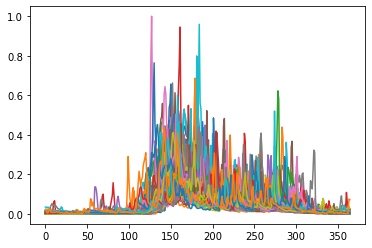

In [684]:
### Normalization! max and min
inflow_scenarios_nor=[]
for year in range(ini_y,end_y+1):
    inflow_scenarios_nor.append(np.array((inflow_scenarios[year]-min_inflow)/(max_inflow-min_inflow)))

for i in range(len(inflow_scenarios)):
    plt.plot(inflow_scenarios_nor[i])
plt.show()

In [685]:
##hyperparameters
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(inflow_scenarios_nor))))## this from one paper
input_len=len(inflow_scenarios_nor[0])
#sig=2
#learning_rate=5
iteration=1000


In [686]:
## star!!!

def training(som_x,som_y,input_len,sig,learning_rate,iteration):
    som = MiniSom(som_x, som_y,input_len, sigma=sig, learning_rate = learning_rate)#random_seed=10,neighborhood_function='gaussian'
    som.random_weights_init(inflow_scenarios_nor)

    start=time.time()
    som.train_batch(inflow_scenarios_nor,iteration, verbose=True)
    end=time.time()-start
    print(end,'seconds')
    return som

In [687]:
from matplotlib.gridspec import GridSpec

win_map = som.win_map(wind_scenarios_d)
# Returns the mapping of the winner nodes and input
plot_som_series_averaged_center(som_x, som_y, win_map)

In [805]:

from hyperopt import fmin, tpe, hp
from hyperopt import Trials,STATUS_OK
space = {
        'sig': hp.uniform('sig',1.3,1.45),
        'learning_rate' : hp.uniform('learning_rate',1.34,1.45)
}

loss_val=[]
def som_fn(space):

    sig=space['sig']
    learning_rate = space['learning_rate']
    val= MiniSom(x=som_x,y=som_y,input_len=input_len,sigma=sig,learning_rate=learning_rate,random_seed=5).quantization_error(inflow_scenarios_nor)#,random_seed=5,neighborhood_function='gaussian'
    loss_val.append(val)
    return {'loss':val,'status':STATUS_OK}

trials =Trials()

best= fmin(
    fn=som_fn,space=space,algo=tpe.suggest,
    max_evals=100,trials=trials)

print('best:{}'.format(best))

for i,trial in enumerate(trials.trials[:1]):

    print(i,trial)


sigma=best['sig']
learning_rate = best['learning_rate']


# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="blue",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

100%|██████████| 100/100 [00:00<00:00, 148.11trial/s, best loss: 1.9963287208426834]
best:{'learning_rate': 1.3461268412801703, 'sig': 1.321873180581822}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 1.9963287208426834, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [1.3461268412801703], 'sig': [1.321873180581822]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2022, 3, 17, 15, 7, 24, 313000), 'refresh_time': datetime.datetime(2022, 3, 17, 15, 7, 24, 319000)}


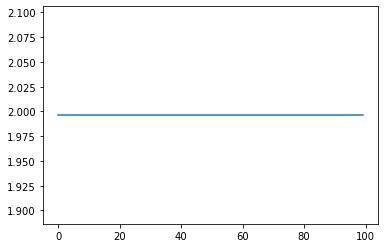

In [806]:
plt.plot(loss_val)

In [807]:
print('x :{}\ny: {}\ninput_len :{}\nsigma: {}\nlearning_rate: {}'.format(som_x,som_y,input_len,sigma,learning_rate))

x :3
y: 3
input_len :365
sigma: 1.321873180581822
learning_rate: 1.3461268412801703


In [808]:
som= training(som_x,som_y,input_len,sigma,learning_rate,iteration)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.8898406407091438
0.11736035346984863 seconds


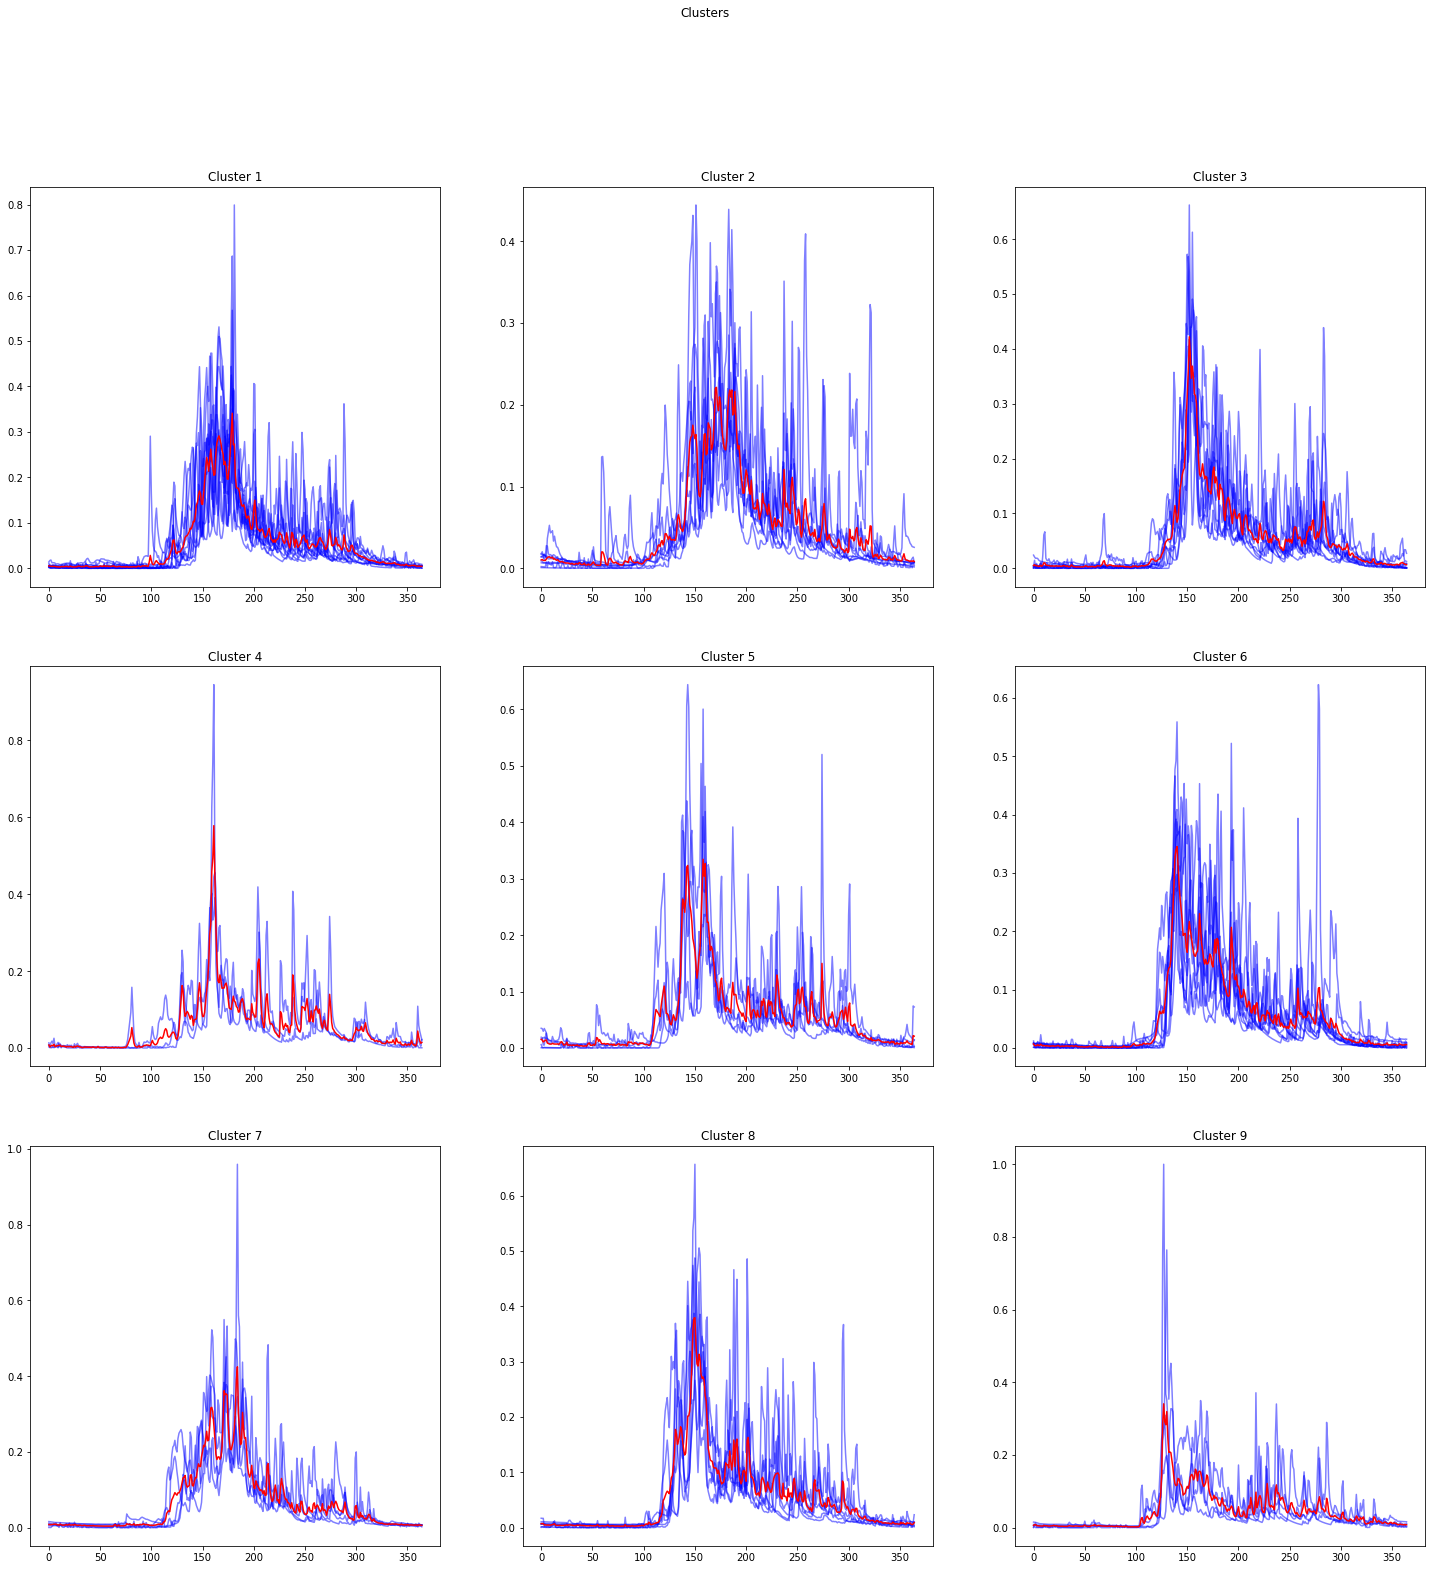

In [809]:
win_map = som.win_map(inflow_scenarios_nor)
plot_som_series_averaged_center(som_x, som_y, win_map)

In [810]:
# Little handy function to plot series
def min_max_figure():
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                axs[cluster].plot(np.min(win_map[cluster], axis=0), color='grey', alpha=.5)
                axs[cluster].plot(np.max(win_map[cluster], axis=0), color='blue', alpha=.1)
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")
    return plt.show()

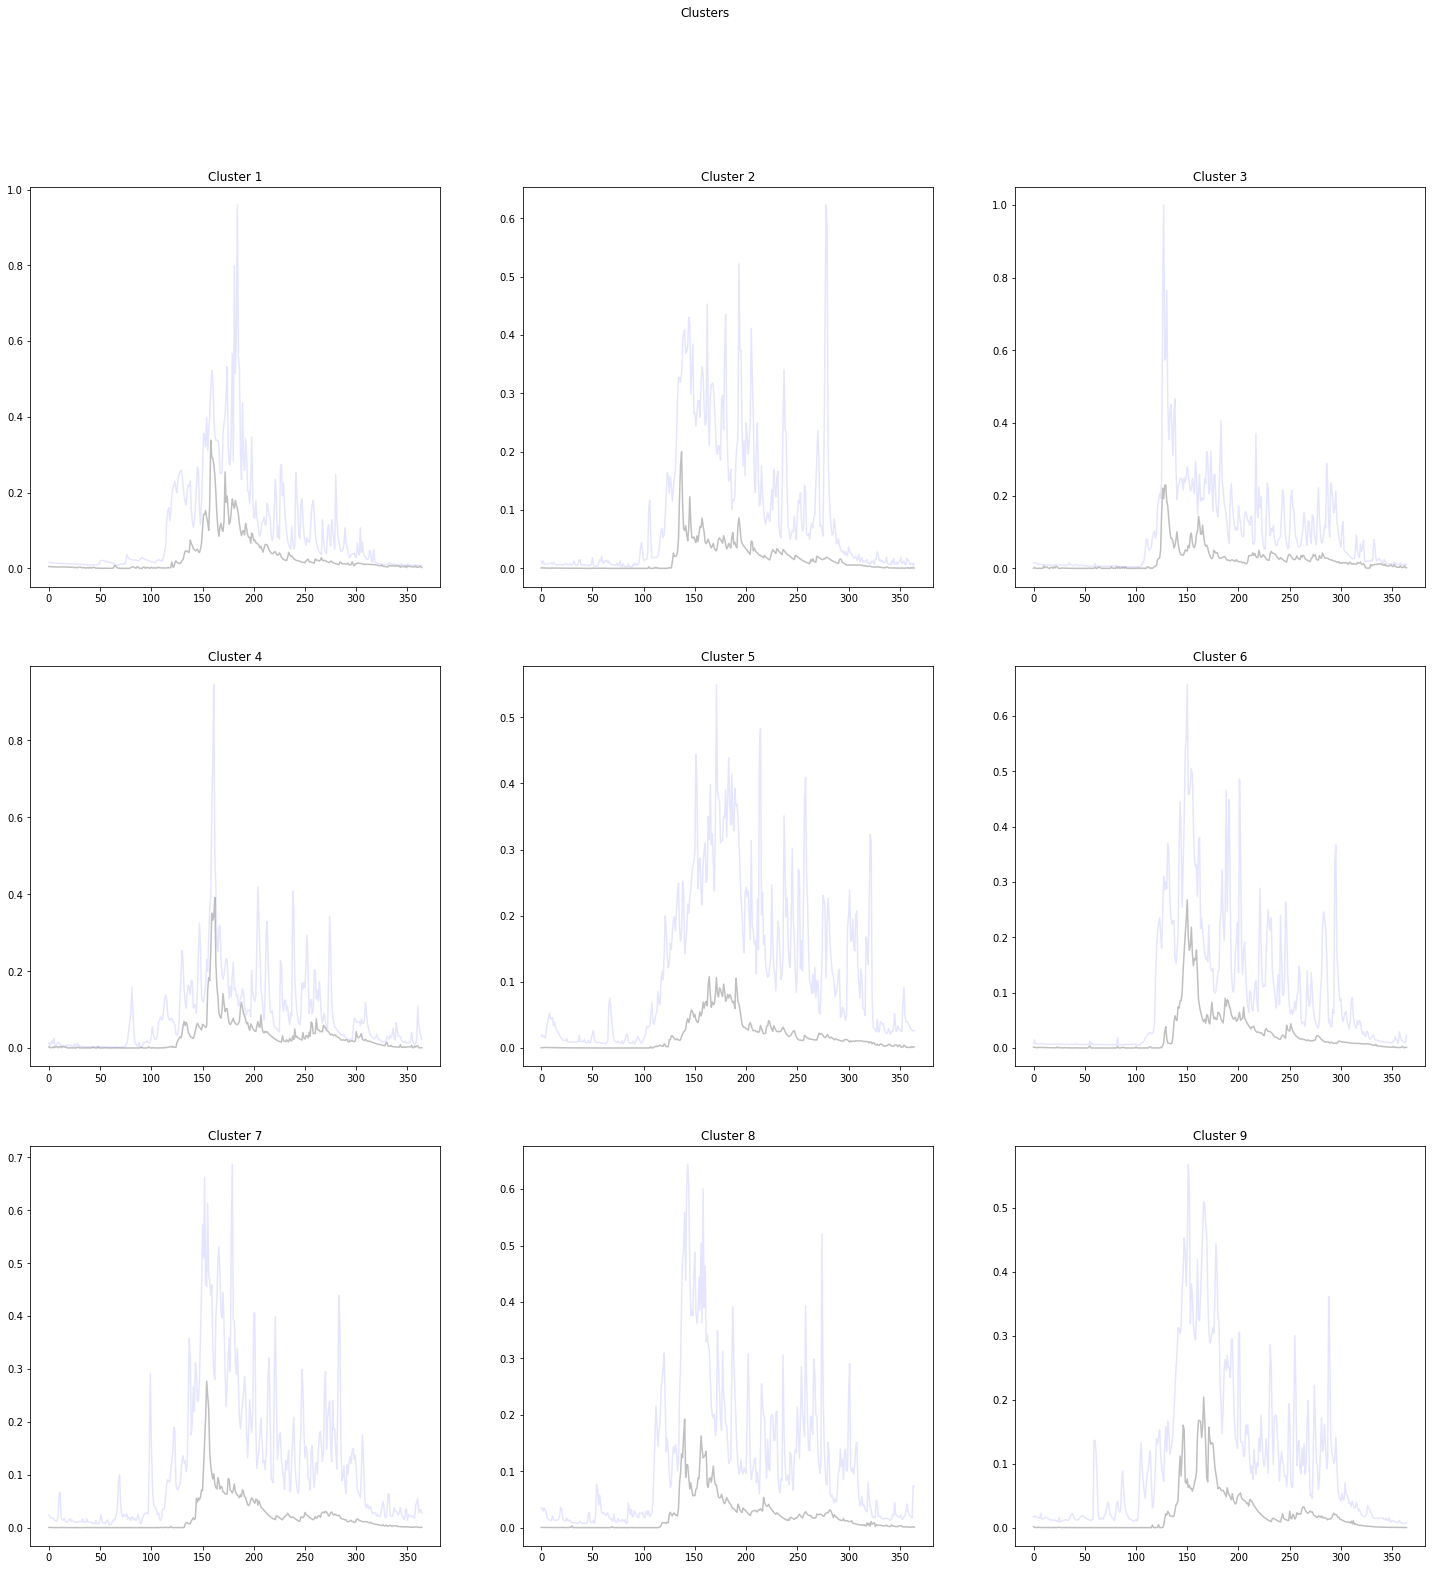

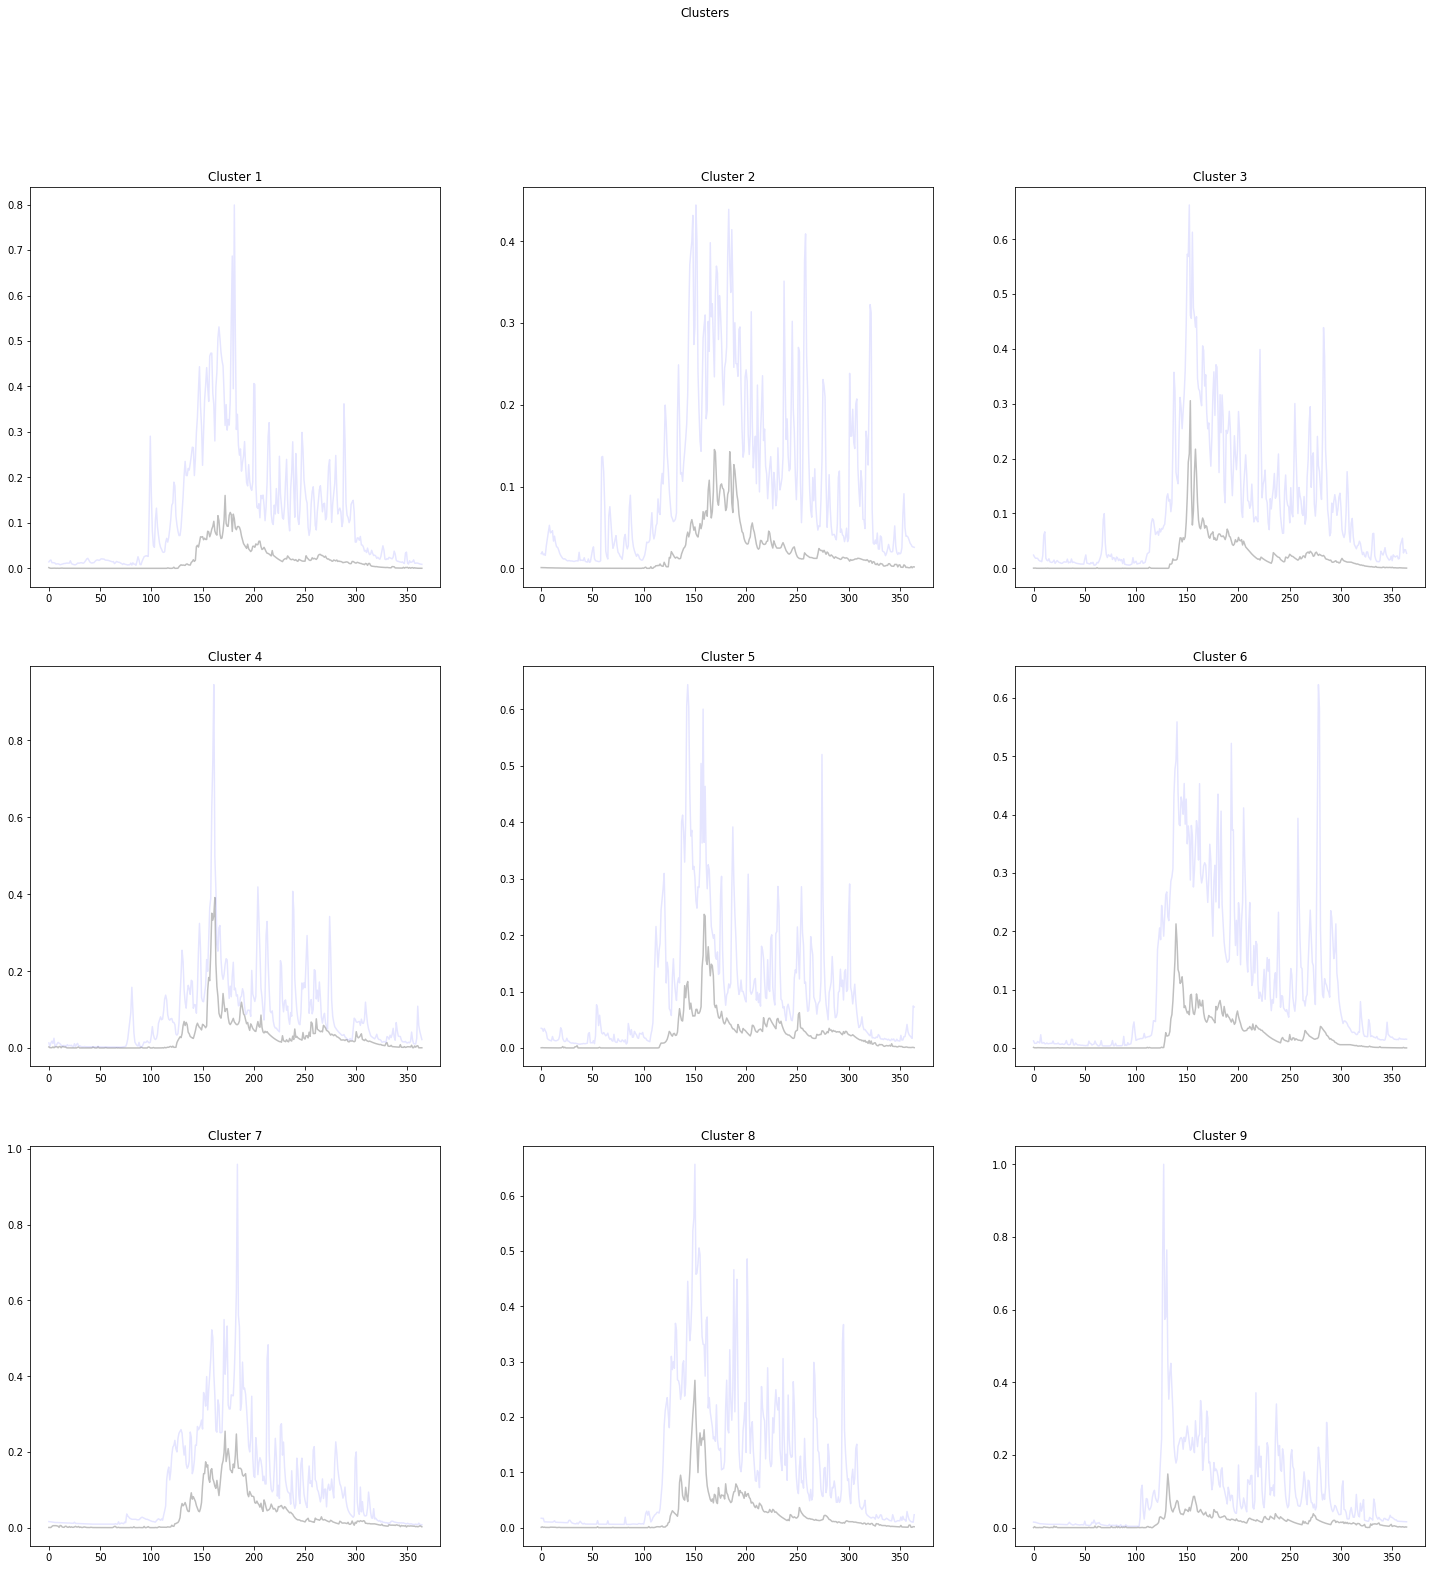

In [811]:
min_max_figure()

## mean absolute error
#this part needs to be  addressed
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_pred)


iteration=9999 status=100.00% error=0.8937415382973717

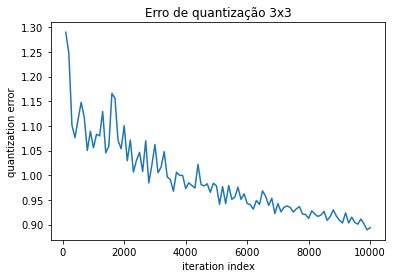

iteration=9999 status=100.00% error=0.8946499006728285

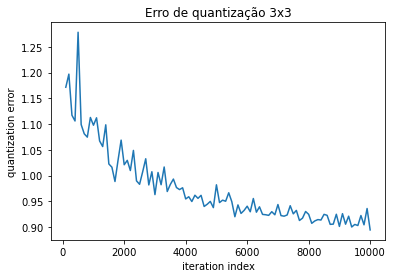

In [812]:
import sys

som.random_weights_init(inflow_scenarios_nor)
max_iter = 10000
q_error_pca_init = []
iter_x = []
for i in range(max_iter):
    percent = 100*(i+1)/max_iter
    rand_i = np.random.randint(len(inflow_scenarios_nor)) # Corresponde ao treinamento randomico
    som.update(inflow_scenarios_nor[rand_i], som.winner(inflow_scenarios_nor[rand_i]), i, max_iter)
    if (i+1) % 100 == 0:
        error = som.quantization_error(inflow_scenarios_nor)
        q_error_pca_init.append(error)
        iter_x.append(i)
        sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}% error={error}')

plt.title('Erro de quantização 3x3')
plt.plot(iter_x, q_error_pca_init)
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.show()

In [814]:
som.distance_map(scaling='sum')

array([[0.3602727 , 0.61968215, 0.36469724],
       [0.70623405, 1.        , 0.73230151],
       [0.42132894, 0.75743351, 0.49473511]])

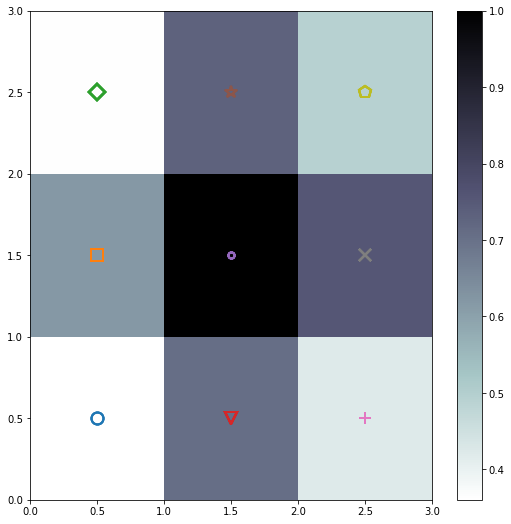

In [855]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = [['o', 's', 'D'],
           ['v','.','*'],
           ['+','x','p']]
colors = [['C0', 'C1', 'C2'],
          ['C3','C4','C5'],
          ['C6','C7','C8']]
for cnt, xx in enumerate(inflow_scenarios_nor):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[w[0]][w[1]], markerfacecolor='None',
             markeredgecolor=colors[w[0]][w[1]], markersize=12, markeredgewidth=2)

plt.show()

In [828]:
markers = [['o', 's', 'D'],
           ['v','.','*',],
           ['+','x','-']]

In [834]:
markers[0][0]

'o'

In [851]:
colors[1][1]

'C4'

1